<h1>DSCI552 FINAL PROJECT</h1>
<p>NAME: DEVEN PARAG NABAR<br>
USERNAME: DEVENNABAR<br>
USCID: 7229446568</p>

In [1]:
import os
from pathlib import Path
import logging
import numpy as np
import random
import tensorflow as tf
from PIL import Image
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import classification_report
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers.experimental.preprocessing import RandomCrop, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
import warnings
warnings.filterwarnings("ignore")
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!wget https://www.dropbox.com/sh/38zygdpo6u7alwy/AAB1PJuhqF-58GZJ-oD4xl5Ya?dl=0

--2023-12-11 03:12:15--  https://www.dropbox.com/sh/38zygdpo6u7alwy/AAB1PJuhqF-58GZJ-oD4xl5Ya?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/38zygdpo6u7alwy/AAB1PJuhqF-58GZJ-oD4xl5Ya [following]
--2023-12-11 03:12:16--  https://www.dropbox.com/sh/raw/38zygdpo6u7alwy/AAB1PJuhqF-58GZJ-oD4xl5Ya
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc70adfb6ac51cc67b359c099eba.dl.dropboxusercontent.com/zip_download_get/Bsn2OjPbxLZQjppaIoTxZf_tFm5-zilqnF2eWSQepGVu6cjiAMJ2tKsPBCxXMi3sUYQqxXGdTlFHl4F0rlNGDHRcWxulJfQAXaMJ_MszI3wVMQ# [following]
--2023-12-11 03:12:17--  https://uc70adfb6ac51cc67b359c099eba.dl.dropboxusercontent.com/zip_download_get/Bsn2OjPbxLZQjppaIoTxZf_tFm5-zilqnF2eWSQepGVu6cjiAMJ2tKsPBCxXMi3sUYQqxXGdTlFHl4F0rlNGDHRcW

In [4]:
import zipfile
with zipfile.ZipFile("/content/AAB1PJuhqF-58GZJ-oD4xl5Ya?dl=0","r") as zip_ref:
    zip_ref.extractall("data")

with zipfile.ZipFile("/content/data/data.zip","r") as zip_ref:
    zip_ref.extractall("data")


In [5]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io

# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes
data_head_dir = Path('./data/data')
# data_head_dir = Path('./drive/MyDrive/data')


# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [6]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
        # print(lines)
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/test_source_images.txt')
# train_ids = load_text_ids('test_source_images.txt')
# validate_ids = load_text_ids('val_source_images.txt')
# test_ids = load_text_ids('test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)


In [7]:
# function taken from Piazza
def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')

        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')

        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 128
batch_size = 64

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

In [8]:
# All Data Augmentation Layers mentioned in the project document
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
    RandomContrast(factor=0.2),
    RandomCrop(height=299, width=299)
])

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns
from yellowbrick.classifier import ClassificationReport



def eval_model(model, tf_data):
    y_true = []
    y_pred = []
    for batch_data, batch_label in tf_data:
        preds = model.predict(batch_data)
        # print(preds)
        # print(batch_label)
        y_true.extend(batch_label.numpy().astype(int))
        y_pred.extend(np.argmax(preds, axis=1).astype(int))
    # print(y_pred)
    # print("##")
    # print(y_true)
    print("confusion_matrix")
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Frost', 'Frost'], yticklabels=['Non-Frost', 'Frost'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print("classification report")
    print(classification_report(y_true, y_pred))




In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import warnings
warnings.filterwarnings('ignore')
from random import sample
import math
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,Activation
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [10]:
from keras.applications import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, RandomCrop

def build_custom_model(input_shape=(299, 299, 3)):
    # Define data augmentation layer
    data_augmentation = Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomTranslation(height_factor=0.2, width_factor=0.2),
        RandomContrast(factor=0.2),
        RandomCrop(height=299, width=299)
    ])

    # Base VGG16 model
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    # Build the custom model
    inputs = Input(shape=input_shape)
    augmented_inputs = data_augmentation(inputs)
    features = base_model(augmented_inputs)
    flattened_features = Flatten()(features)
    normalized_features = BatchNormalization()(flattened_features)
    dropout1 = Dropout(0.2)(normalized_features)
    dense1 = Dense(1024, activation='relu')(dropout1)
    normalized_dense1 = BatchNormalization()(dense1)
    dropout2 = Dropout(0.2)(normalized_dense1)
    output = Dense(1, activation='sigmoid')(dropout2)

    model = Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

# Build the model
custom_model = build_custom_model()

# Display the model summary
custom_model.summary()


58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 batch_normalization (Batch  (None, 41472)             165888    
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 41472)             0      

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history1 = custom_model.fit(tf_dataset_train, epochs=20, verbose=1, validation_data=tf_dataset_val,callbacks=[early_stopping])

Epoch 1/20
464/464 [==============================] - 577s 1s/step - loss: 0.4050 - accuracy: 0.8290 - val_loss: 0.8987 - val_accuracy: 0.5774
Epoch 2/20
464/464 [==============================] - 525s 1s/step - loss: 0.2954 - accuracy: 0.8710 - val_loss: 0.9102 - val_accuracy: 0.6450
Epoch 3/20
464/464 [==============================] - 520s 1s/step - loss: 0.2642 - accuracy: 0.8856 - val_loss: 0.8842 - val_accuracy: 0.6750
Epoch 4/20
464/464 [==============================] - 521s 1s/step - loss: 0.2551 - accuracy: 0.8898 - val_loss: 0.9219 - val_accuracy: 0.6650
Epoch 5/20
464/464 [==============================] - 520s 1s/step - loss: 0.2432 - accuracy: 0.8956 - val_loss: 0.9055 - val_accuracy: 0.6820
Epoch 6/20
464/464 [==============================] - 520s 1s/step - loss: 0.2357 - accuracy: 0.8981 - val_loss: 0.6501 - val_accuracy: 0.7341
Epoch 7/20
464/464 [==============================] - 523s 1s/step - loss: 0.2325 - accuracy: 0.9017 - val_loss: 0.7264 - val_accuracy: 0.7524

In [12]:
test_loss2,test_accuracy2 = custom_model.evaluate(tf_dataset_test)
print("test accuracy - ",test_accuracy2*100, "%")

201/201 [==============================] - 177s 874ms/step - loss: 0.3019 - accuracy: 0.8753
test accuracy -  87.53021955490112 %


In [13]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example usage:
# Assuming you have a variable named 'history' that contains the training history.
# plot_loss(history)


In [14]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage:
# Assuming you have a variable named 'history' that contains the training history.
# plot_accuracy(history)


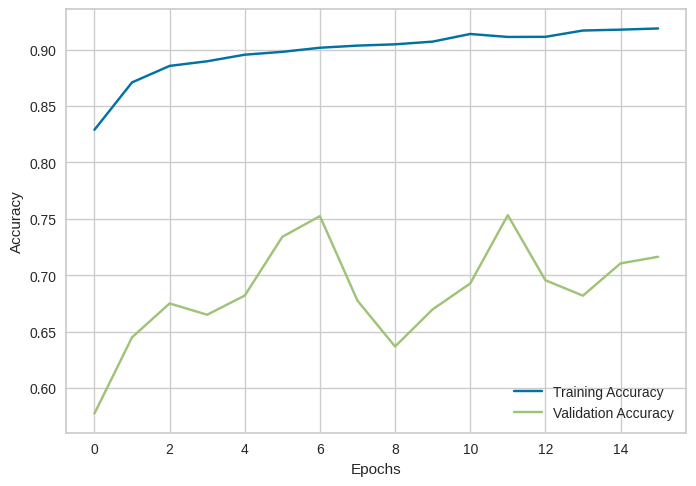

In [17]:
plot_accuracy(history1)

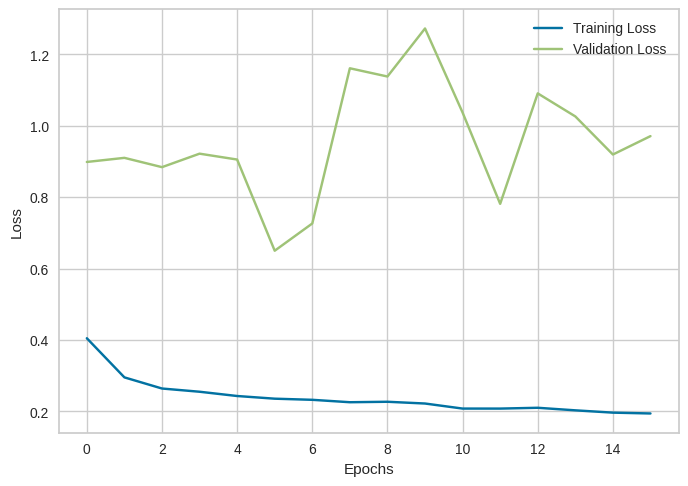

In [18]:
plot_loss(history1)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns
from yellowbrick.classifier import ClassificationReport



def eval_model(model, tf_data):
    y_true = []
    y_pred = []
    for batch_data, batch_label in tf_data:
        preds = model.predict(batch_data)
        # print(preds)
        # print(batch_label)
        y_true.extend(batch_label.numpy().astype(int))
        y_pred.extend(np.argmax(preds, axis=1).astype(int))
    # print(y_pred)
    # print("##")
    # print(y_true)
    # print("confusion_matrix")
    # conf_matrix = confusion_matrix(y_true, y_pred)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
    #             xticklabels=['Non-Frost', 'Frost'], yticklabels=['Non-Frost', 'Frost'])
    # plt.title('Confusion Matrix')
    # plt.xlabel('Predicted Label')
    # plt.ylabel('True Label')
    # plt.show()

    print("classification report")
    print(classification_report(y_true, y_pred))

In [25]:
print("Evaluation for VGG16")
eval_model(custom_model, tf_dataset_test)

Evaluation for VGG16
1/1 [==============================] - 0s 182ms/step
classification report
              precision    recall  f1-score   support

           0       0.34      1.00      0.51      4418
           1       0.00      0.00      0.00      8405

    accuracy                           0.34     12823
   macro avg       0.17      0.50      0.26     12823
weighted avg       0.12      0.34      0.18     12823



In [26]:
from keras.applications import EfficientNetB0
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, RandomCrop

def build_efficientnet_model(input_shape=(299, 299, 3)):


    # Base EfficientNetB0 model
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    # Build the custom model
    inputs = Input(shape=input_shape)
    augmented_inputs = data_augmentation(inputs)
    features = base_model(augmented_inputs)
    flattened_features = Flatten()(features)
    normalized_features = BatchNormalization()(flattened_features)
    dropout1 = Dropout(0.2)(normalized_features)
    dense1 = Dense(1024, activation='relu')(dropout1)
    normalized_dense1 = BatchNormalization()(dense1)
    dropout2 = Dropout(0.2)(normalized_dense1)
    output = Dense(1, activation='sigmoid')(dropout2)

    model = Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

# Build the EfficientNetB0 model
efficientnet_model = build_efficientnet_model()

# Display the model summary
efficientnet_model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 10, 10, 1280)      4049571   
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 batch_normalization_2 (Bat  (None, 128000)            512000    
 chNormalization)                                                
                                                            

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history2 = efficientnet_model.fit(tf_dataset_train, epochs=20, verbose=1, validation_data=tf_dataset_val, callbacks=[early_stopping])

Epoch 1/20
464/464 [==============================] - 444s 929ms/step - loss: 0.7930 - accuracy: 0.5465 - val_loss: 0.6936 - val_accuracy: 0.6086
Epoch 2/20
464/464 [==============================] - 373s 803ms/step - loss: 0.7130 - accuracy: 0.5586 - val_loss: 0.7958 - val_accuracy: 0.2850
Epoch 3/20
464/464 [==============================] - 362s 779ms/step - loss: 0.6976 - accuracy: 0.5674 - val_loss: 0.8727 - val_accuracy: 0.3215
Epoch 4/20
464/464 [==============================] - 364s 783ms/step - loss: 0.6899 - accuracy: 0.5719 - val_loss: 0.8277 - val_accuracy: 0.3094
Epoch 5/20
464/464 [==============================] - 365s 786ms/step - loss: 0.6889 - accuracy: 0.5768 - val_loss: 0.8110 - val_accuracy: 0.2963
Epoch 6/20
464/464 [==============================] - 366s 788ms/step - loss: 0.6873 - accuracy: 0.5731 - val_loss: 0.8642 - val_accuracy: 0.3218
Epoch 7/20
464/464 [==============================] - 413s 889ms/step - loss: 0.6832 - accuracy: 0.5756 - val_loss: 0.8901 -

In [28]:
test_loss3,test_accuracy3 = custom_model.evaluate(tf_dataset_test)
print("test accuracy - ",test_accuracy3*100, "%")

201/201 [==============================] - 180s 894ms/step - loss: 0.3019 - accuracy: 0.8753
test accuracy -  87.53021955490112 %


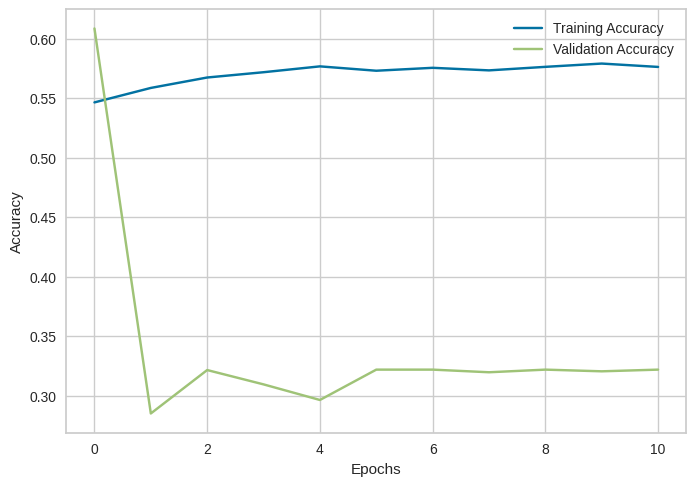

In [29]:
plot_accuracy(history2)

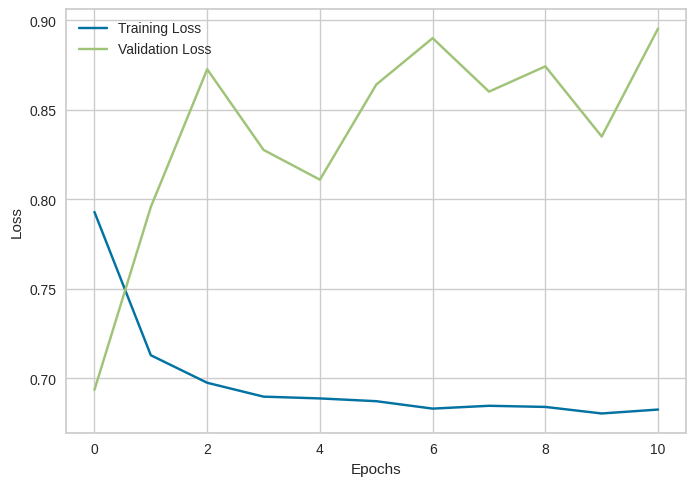

In [30]:
plot_loss(history2)

In [31]:
print("Evaluation for EfficientNetB0")
eval_model(efficientnet_model, tf_dataset_test)

Evaluation for EfficientNetB0
1/1 [==============================] - 3s 3s/step
classification report
              precision    recall  f1-score   support

           0       0.34      1.00      0.51      4418
           1       0.00      0.00      0.00      8405

    accuracy                           0.34     12823
   macro avg       0.17      0.50      0.26     12823
weighted avg       0.12      0.34      0.18     12823

